<a href="https://colab.research.google.com/github/pythagoras-yamamoto/visualize_embedding_fake_news/blob/main/visualize_embedding_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 埋め込み表現によるフェイクニュースの情報信頼性評価手法の提案


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 10-2
!pip install transformers==4.18.0 fugashi==1.1.0 ipadic==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 10-3
import random
import glob
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel

# BERTの英語モデル
MODEL_NAME = 'bert-base-uncased'

### データ読み込みと前処理

In [ ]:
# load the dataset
news_d = pd.read_csv("/content/drive/MyDrive/transformers/Data/news.csv")
print("Shape of News data:", news_d.shape)
print("News data columns:", news_d.columns)
news_d.head()

Shape of News data: (6335, 4)
News data columns: Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
news_d_text = news_d.loc[:, ['text']]
print("Shape of News data:", news_d_text.shape)
print("News data columns:", news_d_text.columns)

news_d_text.head()

text = news_d_text['text'].tolist()
print(type(text))

Shape of News data: (6335, 1)
News data columns: Index(['text'], dtype='object')
<class 'list'>


In [ ]:
news_d_label = news_d.loc[:, ['label']]
print("Shape of News data:", news_d_label.shape)
print("News data columns:", news_d_label.columns)

news_d_label.head()

labels = news_d_label['label'].tolist()
print(type(labels))

Shape of News data: (6335, 1)
News data columns: Index(['label'], dtype='object')
<class 'list'>


In [ ]:
# 10-5

# トークナイザとモデルのロード
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model = model.cuda()
 
# 各データの形式を整える
max_length = 512
sentence_vectors = [] # 文章ベクトルを追加していく。 

for i in tqdm(text):
    encoding = tokenizer(
        i, 
        max_length=max_length, 
        padding='max_length', 
        truncation=True, 
        return_tensors='pt'
    )
    # print(encoding)

    encoding = { k: v.cuda() for k, v in encoding.items() } 
    attention_mask = encoding['attention_mask']

# 文章ベクトルを計算
# BERTの最終層の出力を平均を計算する。（ただし、[PAD]は除く。）
    with torch.no_grad():
        output = model(**encoding)
        last_hidden_state = output.last_hidden_state 
        averaged_hidden_state = \
            (last_hidden_state*attention_mask.unsqueeze(-1)).sum(1) \
            / attention_mask.sum(1, keepdim=True) 

        # 文章ベクトルとラベルを追加
        sentence_vectors.append(averaged_hidden_state[0].cpu().numpy())

print(sentence_vectors)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 6335/6335 [04:50<00:00, 21.80it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in ord

In [ ]:
# import csv

# csv_file_sentence = open("/content/drive/MyDrive/Colab Notebooks/visualize-embedding-fake-news-data/sentence_vectors.csv", "r", encoding="ms932", errors="", newline="" )
# csv_file_label = open("/content/drive/MyDrive/Colab Notebooks/visualize-embedding-fake-news-data/labels.csv", "r", encoding="ms932", errors="", newline="" )


# #リスト形式
# sentence_vectors = csv.reader(csv_file_sentence, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
# labels = csv.reader(csv_file_label, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)


In [ ]:
# # それぞれをnumpy.ndarrayにする。
# import numpy as np

# labels = np.array(news_d_label['label'].tolist())
# sentence_vectors = np.vstack(sentence_vectors)

# df_label = pd.DataFrame(labels)
# df_label.to_csv("/content/drive/MyDrive/Colab Notebooks/visualize-embedding-fake-news-data/label.csv")

# df_sentence_vectors  = pd.DataFrame(sentence_vectors)
# df_sentence_vectors.to_csv("/content/drive/MyDrive/Colab Notebooks/visualize-embedding-fake-news-data/sentence_vectors.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


NameError: ignored

In [ ]:
category_list = [
    'FAKE',
    'REAL'
]

# それぞれをnumpy.ndarrayにする。
labels = np.array(news_d_label['label'].tolist())
sentence_vectors = np.vstack(sentence_vectors)

# 中身の確認
for sentence_vector, label in zip(sentence_vectors[:5], labels[:5]):
  print(sentence_vector, label)

df = pd.DataFrame(sentence_vectors)
df['target'] = labels

print(df)

print("Shape of News data:", labels.shape)
print("Shape of News data:", sentence_vectors.shape)

[-9.37035084e-02 -1.55437768e-01  1.21640980e-01 -7.55247250e-02
  7.46641904e-02 -1.91954449e-01 -1.19457049e-02  4.78923440e-01
 -6.29031658e-02 -2.58717965e-02  1.80493176e-01 -3.15337539e-01
 -3.39629084e-01  3.15083981e-01 -2.12486565e-01  4.45736587e-01
  2.53014028e-01  1.65167376e-01 -2.11974889e-01  2.85969913e-01
  4.22646105e-01 -2.66134180e-02 -2.63488479e-03  5.26741862e-01
  2.34221041e-01  3.34203020e-02 -4.49408591e-02 -2.18389347e-01
 -1.63993746e-01 -1.20382160e-02  6.59056664e-01 -9.27222520e-02
 -1.40030444e-01 -1.93250641e-01  1.58893883e-01 -1.69909950e-02
  7.13568777e-02 -3.04631978e-01 -7.08311647e-02  3.34756643e-01
 -5.71005583e-01 -2.60160059e-01 -3.07930797e-01  2.43581310e-01
 -2.10325897e-01 -2.13051200e-01  3.37852120e-01  1.70874119e-01
  1.95733041e-01  2.15293765e-02 -2.59518296e-01  4.38792616e-01
 -5.48148192e-02 -1.30053490e-01  2.54607260e-01  5.46999514e-01
  2.83892304e-02 -4.08225954e-01 -3.85653675e-01 -2.73089945e-01
 -4.16318700e-02 -9.41032

In [ ]:
# 10-6
from sklearn.preprocessing import StandardScaler

#標準化
X = StandardScaler().fit_transform(sentence_vectors)
print(X)

y = df['target'].values
print(y)

#sentence_vectors_pcaはpca
sentence_vectors_pca = PCA(n_components=2)
sentence_vectors_pca.fit(X)
X_pc = sentence_vectors_pca.transform(X)

y = y.reshape(-1, 1)
df_pc = pd.DataFrame(np.concatenate([X_pc, y], axis=1), columns=['first component', 'second component', 'labels']).astype({'first component':float, 'second component':float})

[[ 0.5406043  -0.44900993 -0.5132186  ...  0.58314466  0.88977534
   0.3166677 ]
 [ 0.4748204  -0.17754392  0.7492567  ...  0.8227522   0.2719627
  -0.01148356]
 [-0.6041651  -0.6064211  -0.34119922 ...  0.90470237 -0.21328281
  -0.33548957]
 ...
 [ 0.2561804  -0.14696763  0.27958706 ... -1.1839418   0.31801257
   1.5083301 ]
 [-1.254005    0.23571447 -1.0747677  ... -0.41550535 -0.6655707
  -1.5985885 ]
 [-0.95469433 -0.538958   -0.61595345 ...  0.38381416  0.05270952
  -0.00662974]]
['FAKE' 'FAKE' 'REAL' ... 'FAKE' 'REAL' 'REAL']


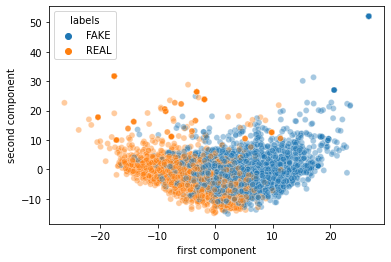

In [ ]:
import seaborn as sns

sns.scatterplot(x='first component', y='second component', hue='labels', alpha  = 0.4, data=df_pc)

In [ ]:
from sklearn.preprocessing import StandardScaler

#標準化
X = StandardScaler().fit_transform(sentence_vectors)
print(X)

y = df['target'].values
print(y)

#sentence_vectors_pcaはpca
sentence_vectors_tsne = TSNE(n_components=2)
X_pc = sentence_vectors_tsne.fit_transform(X)

y = y.reshape(-1, 1)
df_pc = pd.DataFrame(np.concatenate([X_pc, y], axis=1), columns=['first component', 'second component', 'labels']).astype({'first component':float, 'second component':float})

[[ 0.5406043  -0.44900993 -0.5132186  ...  0.58314466  0.88977534
   0.3166677 ]
 [ 0.4748204  -0.17754392  0.7492567  ...  0.8227522   0.2719627
  -0.01148356]
 [-0.6041651  -0.6064211  -0.34119922 ...  0.90470237 -0.21328281
  -0.33548957]
 ...
 [ 0.2561804  -0.14696763  0.27958706 ... -1.1839418   0.31801257
   1.5083301 ]
 [-1.254005    0.23571447 -1.0747677  ... -0.41550535 -0.6655707
  -1.5985885 ]
 [-0.95469433 -0.538958   -0.61595345 ...  0.38381416  0.05270952
  -0.00662974]]
['FAKE' 'FAKE' 'REAL' ... 'FAKE' 'REAL' 'REAL']


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


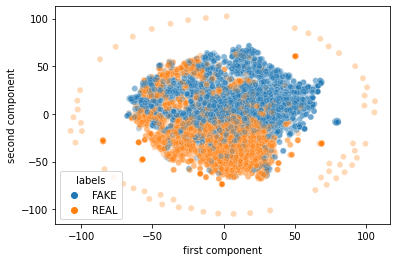

In [ ]:
sns.scatterplot(x='first component', y='second component', hue='labels', alpha  = 0.3, data=df_pc)

In [ ]:
# UMAP
!pip install umap-learn
import umap
from scipy.sparse.csgraph import connected_components
from sklearn.preprocessing import StandardScaler


#標準化
X = StandardScaler().fit_transform(sentence_vectors)
print(X)

y = df['target'].values
print(y)

#sentence_vectors_pcaはpca
sentence_vectors_umap = umap.UMAP(n_components=2)
X_pc = sentence_vectors_umap.fit_transform(X)

y = y.reshape(-1, 1)
df_pc = pd.DataFrame(np.concatenate([X_pc, y], axis=1), columns=['first component', 'second component', 'labels']).astype({'first component':float, 'second component':float})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[[ 0.5406043  -0.44900993 -0.5132186  ...  0.58314466  0.88977534
   0.3166677 ]
 [ 0.4748204  -0.17754392  0.7492567  ...  0.8227522   0.2719627
  -0.01148356]
 [-0.6041651  -0.6064211  -0.34119922 ...  0.90470237 -0.21328281
  -0.33548957]
 ...
 [ 0.2561804  -0.14696763  0.27958706 ... -1.1839418   0.31801257
   1.5083301 ]
 [-1.254005    0.23571447 -1.0747677  ... -0.41550535 -0.6655707
  -1.5985885 ]
 [-0.95469433 -0.538958   -0.61595345 ...  0.38381416  0.05270952
  -0.00662974]]
['FAKE' 'FAKE' 'REAL' ... 'FAKE' 'REAL' 'REAL']


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


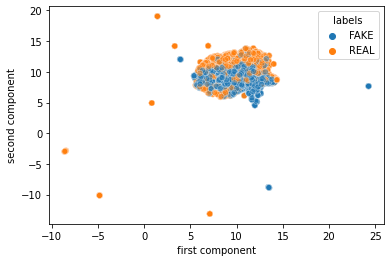

In [ ]:
sns.scatterplot(x='first component', y='second component', hue='labels', alpha  = 0.5, data=df_pc)

In [ ]:
# 10-10
# 先にノルムを1にしておく。
norm = np.linalg.norm(sentence_vectors, axis=1, keepdims=True) 
sentence_vectors_normalized = sentence_vectors / norm

# 類似度行列を計算する。
# 類似度行列の(i,j)要素はi番目の記事とj番目の記事の類似度を表している。
sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)

# 入力と同じ記事が出力されることを避けるため、
# 類似度行列の対角要素の値を小さくしておく。
np.fill_diagonal(sim_matrix, -1)

# 類似度が高い記事のインデックスを得る
similar_news = sim_matrix.argmax(axis=1) 

# 類似文章検索により選ばれた記事とカテゴリーが同一であった記事の割合を計算
input_news_categories = labels
output_news_categories = labels[similar_news]
num_correct = ( input_news_categories == output_news_categories ).sum()
accuracy = num_correct / labels.shape[0]

print(f"Accuracy: {accuracy:.2f}")

# 次元削減の箇所のみ実行したい場合↓

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
news_d = pd.read_csv("/content/drive/MyDrive/transformers/Data/news.csv")
news_d_label = news_d.loc[:, ['label']]
labels = news_d_label['label'].tolist()

print(np.shape(labels))

(6335,)


In [ ]:
sentence_vectors = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/visualize-embedding-fake-news-data/sentence_vectors.csv").values.tolist()
print(np.shape(sentence_vectors))
# labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/visualize-embedding-fake-news-data/labels.csv").values.tolist()

(6336, 770)


In [ ]:
# numpy.ndarray形式化
labels = np.array(labels)
sentence_vectors = np.vstack(sentence_vectors)
# DataTrame形式化
# df_label = pd.DataFrame(labels)
# df_sentence_vectors  = pd.DataFrame(sentence_vectors)

# print(df_label)
# print(df_sentence_vectors)

In [ ]:
# 10-6
from sklearn.preprocessing import StandardScaler

#標準化
X = StandardScaler().fit_transform(sentence_vectors)
print(X)

y = labels
print(y)

#sentence_vectors_pcaはpca
sentence_vectors_pca = PCA(n_components=2)
sentence_vectors_pca.fit(X)
X_pc = sentence_vectors_pca.transform(X)

y = y.reshape(-1, 1)
df_pc = pd.DataFrame(np.concatenate([X_pc, y], axis=1), columns=['first component', 'second component', 'labels']).astype({'first component':float, 'second component':float})

[[-1.73177746e+00             nan  1.10264680e+00 ...  7.95882243e+01
   7.95878833e+01  7.95878624e+01]
 [-1.73123073e+00 -1.73177742e+00  5.40421055e-01 ... -6.36952220e-03
  -2.76026076e-03 -9.06682069e-03]
 [-1.73068400e+00 -1.73123060e+00  4.74638247e-01 ... -3.82458825e-03
  -9.56690159e-03 -1.26899902e-02]
 ...
 [ 1.73068400e+00  1.73068378e+00  2.56001945e-01 ... -2.51382146e-02
  -9.05955551e-03  4.09050910e-03]
 [ 1.73123073e+00  1.73123060e+00 -1.25415766e+00 ... -1.69764473e-02
  -1.98960072e-02 -3.02134637e-02]
 [ 1.73177746e+00  1.73177742e+00 -9.54852123e-01 ... -8.48666431e-03
  -1.19824841e-02 -1.26363985e-02]]
['FAKE' 'FAKE' 'REAL' ... 'FAKE' 'REAL' 'REAL']


ValueError: ignored